In [1]:
import wrds
import pandas as pd
import os
import json
from datetime import datetime
import re

In [2]:
# set the directory path
directory = "Articles"

# initialize an empty list to store the data
data = []

# loop through each directory in the Articles directory
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):
        # loop through each file in the directory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            if os.path.isfile(file_path) and filename.endswith(".json"):
                # read the JSON file
                with open(file_path, "r") as f:
                    json_obj = json.load(f)
                # extract the relevant information from the JSON object
                _id = json_obj["_id"]
                #name of the directory is the company name
                company = subdir
                title = json_obj["title"]
                text = json_obj["text"]
                cleaned_text = re.sub(r'<p>|</p>', '', text)
                #Change to timestamp YYYY-MM-DD HH:MM:SS
                published = json_obj["published"]
                timestamp = datetime.strptime(published, '%Y-%m-%dT%H:%M:%S.%fZ')
                data.append([_id, company, title, cleaned_text, timestamp])
        
df = pd.DataFrame(data, columns=["id", "company", "title", "text", "published"])

In [3]:
#Remove duplicates texts
df = df.sort_values(['company', 'published'])
df = df.drop_duplicates(subset=['text'], keep='first')

#Remove id column
df = df.reset_index(drop=True)
df = df.drop(['id'], axis=1)

In [4]:
#print company names
company_to_ticker = {
    '3M_Company': 'MMM',
    'American_Express_co': 'AXP',
    'Amgen_Inc': 'AMGN',
    'Apple_Inc': 'AAPL',
    'Boeing_Co': 'BA',
    'Caterpillar_Inc': 'CAT',
    'Chevron_Corporation': 'CVX',
    'Cisco_Systems_Inc': 'CSCO',
    'Coca_Cola_Co': 'KO',
    'Dow_Inc': 'DOW',
    'Goldman_Sachs_Group_Inc': 'GS',
    'Home_Depot_Inc': 'HD',
    'Honeywell_International_Inc': 'HON',
    'Intel_Corporation': 'INTC',
    'International_Business_Machines_Corporation': 'IBM',
    'JPMorgan_Chase_Co': 'JPM',
    'Johnson_Johnson': 'JNJ',
    'McDonald_s_Corporation': 'MCD',
    'Merck_Co_Inc': 'MRK',
    'Microsoft_Corporation': 'MSFT',
    'Nike_Inc': 'NKE',
    'Procter_Gamble_Co': 'PG',
    'Salesforce_Inc': 'CRM',
    'The_Walt_Disney_Company': 'DIS',
    'Travelers_Companies_Inc': 'TRV',
    'Unitedhealth_Group_Incorporated': 'UNH',
    'Verizon_communications_Inc': 'VZ',
    'Visa_Inc': 'V',
    'Walgreens_Boots_Alliance_Inc': 'WBA',
    'Walmart_Inc': 'WMT'
}

#Replace company names with ticker symbols
df['company'] = df['company'].replace(company_to_ticker)

In [5]:
#Get per company date of first and last article
df_date = df.copy()
grouped = df_date.groupby('company')['published'].agg(['min', 'max'])

In [7]:
#Helpers functions for cleaning text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_ftcom_and_after(text):
    index = text.find("FT.com")
    return text[:index] if index != -1 else text

def remove_source_and_after(text) : 
    index  = text.find("Source:")
    return text[:index] if index != -1 else text


In [8]:
financial_times_news_df = df[df['text'].str.contains('Financial Times')]
financial_times_news_df.text.values[0]

'For cold-blooded markets, the big political event of the week was not so much the lawless mob storming the <a href="https://www.ft.com/content/9a37c259-f7c8-4cca-9a00-83e7e5b9287d">US Capitol building</a>. Individual investors were shocked and repulsed by the events in Washington spurred by the rages of Donald Trump in the final days of his tumultuous presidency. But after a brief wobble on Wednesday, US and global equities resumed their recent trend of setting all-time highs.  Investors appeared to be looking ahead to the transfer of power that culminates in the inauguration of Joe Biden as US president this month — a succession belatedly <a href="https://www.ft.com/content/15f932cf-b8e5-4c24-b0d5-1ef903103a3c">acknowledged</a> by Mr Trump. “Markets, rightly in our view, see the US government as ultimately a stable enough set of institutions even if things occasionally go pear-shaped,” said Nicholas Colas, co-founder of independent research house DataTrek.  Of greater significance to

In [9]:
#For financial times news, remove in the text the following:   
financial_times_news_df = df[df['text'].str.contains('Financial Times')]

#Remove html tags
financial_times_news_copy_df = financial_times_news_df.copy()
financial_times_news_copy_df['text'] = financial_times_news_copy_df['text'].apply(remove_html_tags)

#Remove FT.com and after
financial_times_news_copy_df['text'] = financial_times_news_copy_df['text'].apply(remove_ftcom_and_after)

#Remove Source: and after
financial_times_news_copy_df['text'] = financial_times_news_copy_df['text'].apply(remove_source_and_after)

#Remove &#xa0; and replace with space
financial_times_news_copy_df['text'] = financial_times_news_copy_df['text'].str.replace('&#xa0;', ' ')

#Remove "Follow @FT" and after
financial_times_news_copy_df['text'] = financial_times_news_copy_df['text'].apply(lambda x: x.split("Follow @FT")[0])

#Remove rows with "Please sign up here
financial_times_news_copy_df = financial_times_news_copy_df[financial_times_news_copy_df['text'] != "Please sign up here"]

#Keep rows that contain "FT"
financial_times_news_copy_df = financial_times_news_copy_df[financial_times_news_copy_df['text'].str.contains('FT')]
financial_times_news_copy_df

,company,title,text,published
18,MMM,The race to scale up green hydrogen,This article is the first in a FT series exami...,2021-03-08 05:00:20.722
19,MMM,Biden zaps the power from Trump's ESG rules,"Hello from New York, where the weather has war...",2021-03-12 12:00:23.869
32,MMM,FirstFT: Today's top stories,Six states including Texas and Florida will ga...,2021-04-27 11:16:07.164
46,MMM,"Spencer Silver, chemist and inventor 1941-2021","The career of Spencer Silver, the American che...",2021-05-21 13:53:49.868
48,MMM,Amigo thrown into crisis after court rejects s...,Amigo is in crisis after the High Court reject...,2021-05-25 08:08:47.334
...,...,...,...,...
74085,WMT,Opposition shadows Cerberus windfall from Albe...,Broadening scrutiny of a US supermarket megame...,2022-11-09 05:00:09.148
74178,WMT,FirstFT: The worst corporate collapse for 40 y...,"The new chief executive of FTX, an insolvency ...",2022-11-18 11:25:33.431
74183,WMT,The Lex Newsletter: Ukraine boosts fortunes of...,"Before getting started, a quick plug for Lex P...",2022-11-18 17:00:21.911
74187,WMT,Lex populi: Rate-sensitive UK property stocks ...,"Lex Populi is a new FT Money column from Lex, ...",2022-11-19 05:00:23.293


In [10]:
#Replace the rows in the original df with the cleaned text
df.loc[financial_times_news_copy_df.index, 'text'] = financial_times_news_copy_df['text']

In [11]:
#Save the dataframe to a csv file
df.to_csv('news.csv', index=False)

In [27]:
AAPL_df = df[df['company'] == 'AAPL']
#keep the rows with 'Listen on podcast' in the text
AAPL_df = AAPL_df[AAPL_df['text'].str.contains('Listen on:')]
AAPL_df.text.values[0]

"Subscribers to The Economist can join our finance reporters John O'Sullivan, Buttonwood columnist, and Alice Fulwood, Wall Street correspondent, on July 29th for a live event unpicking the inner workings of financial markets and how to make sense of them. Register and submit your questions at economist.com/marketsevent  can join our finance reporters John O'Sullivan, Buttonwood columnist, and Alice Fulwood, Wall Street correspondent, on July 29th for a live event unpicking the inner workings of financial markets and how to make sense of them. Register and submit your questions atListen on: Apple Podcasts  | Spotify  | Google  | Stitcher  | TuneIn  |For full access to print, digital and audio editions as well as exclusive live events, subscribe to The Economist at economist.com/podcastoffer  at"

In [12]:
#Import stocks performance data from yahoo finance
import yfinance as yf

stocks = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'INTC', 'IBM', 'JPM', 'JNJ', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'DIS', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT']
data = yf.download(stocks, start="2020-01-01", end="2022-12-31")

[*********************100%%**********************]  30 of 30 completed


In [13]:
#Create a new dataframe with only the closing prices
df_close = data['Close']
df_close = df_close.reset_index()
df_close = df_close.rename(columns={'index':'Date'})

In [14]:
df_close

,Date,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,2020-01-02,75.087502,240.100006,125.849998,333.320007,150.529999,166.990005,48.419998,121.430000,148.199997,...,87.824425,160.619995,102.199997,123.410004,137.509995,292.500000,191.119995,61.049999,59.080002,118.940002
1,2020-01-03,74.357498,238.470001,124.599998,332.760010,148.440002,166.169998,47.630001,121.010002,146.500000,...,87.070610,158.619995,101.919998,122.580002,137.020004,289.540009,189.600006,60.400002,59.080002,117.889999
2,2020-01-06,74.949997,240.300003,124.059998,333.739990,148.339996,173.449997,47.799999,120.599998,145.649994,...,87.442749,159.029999,101.830002,122.750000,137.169998,291.549988,189.190002,60.270000,59.590000,117.650002
3,2020-01-07,74.597504,238.039993,123.410004,337.279999,146.380005,176.000000,47.490002,119.059998,145.699997,...,85.114502,157.580002,101.779999,121.989998,135.160004,289.790009,188.690002,59.599998,59.290001,116.559998
4,2020-01-08,75.797501,238.220001,125.540001,331.369995,147.679993,177.330002,47.520000,117.699997,145.399994,...,84.541985,160.089996,101.550003,122.510002,136.610001,295.899994,191.919998,59.709999,55.830002,116.160004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2022-12-23,131.860001,263.920013,147.020004,189.059998,239.869995,129.440002,47.480000,177.399994,88.010002,...,111.860001,238.729996,116.250000,152.619995,189.479996,531.309998,205.830002,38.410000,38.630001,143.770004
752,2022-12-27,130.029999,263.390015,146.389999,189.399994,243.139999,130.660004,47.529999,179.630005,86.370003,...,112.120003,236.960007,117.559998,153.949997,190.479996,531.989990,206.289993,39.250000,38.310001,143.809998
753,2022-12-28,126.040001,261.420013,144.009995,188.380005,239.380005,128.470001,47.070000,176.979996,84.169998,...,111.080002,234.529999,114.980003,151.960007,188.130005,528.450012,204.990005,38.810001,37.580002,141.289993
754,2022-12-29,129.610001,263.160004,147.320007,188.910004,240.199997,132.539993,47.500000,178.320007,87.180000,...,110.820000,241.009995,117.349998,152.589996,189.440002,529.880005,208.059998,39.259998,37.470001,142.149994


<Axes: xlabel='Date', ylabel='AAPL'>

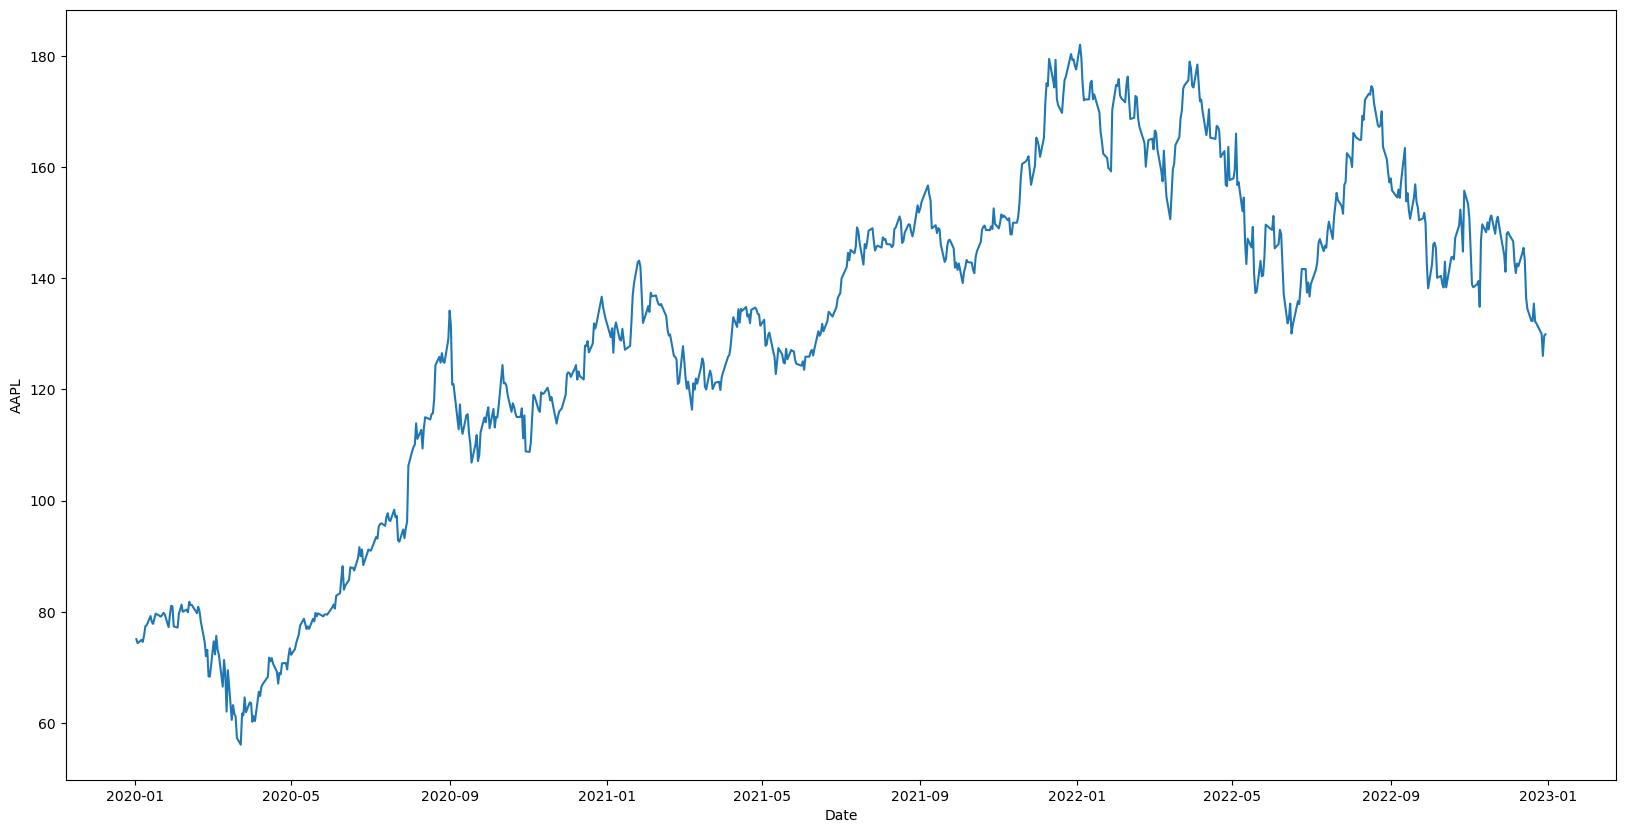

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.lineplot(x="Date", y="AAPL", data=df_close)

In [19]:
AAPL_news = non_finanical_times_news_df[non_finanical_times_news_df['company'] == 'AAPL']
AAPL_news = AAPL_news.reset_index(drop=True)
AAPL_news['text'].apply(lambda x: len(x.split(' '))).sum()/len(AAPL_news)

826.050703226569

In [29]:
#Remove the rows with more than 512 words
AAPL_news = AAPL_news[AAPL_news['text'].apply(lambda x: len(x.split(' '))) < 100]
AAPL_news = AAPL_news.reset_index(drop=True)

len(AAPL_news.text.values)

204

In [30]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = AAPL_news.text.values


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: 
BertForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.
